<a href="https://colab.research.google.com/github/sal2212/HIFU-Filter-GAN/blob/main/HIFU_filter_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time
import scipy.io as io
import h5py
import sys
import datetime
import subprocess

from PIL import Image
from IPython import display
from natsort import natsorted, ns

import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [ ]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [ ]:
project_root = 'B:\Filter-AI'
rcvdata_url = "https://storage.googleapis.com/skull-data/rcvdataHIFU.zip"
rcvdata_file = os.path.join(project_root, "rcvdataHIFU.zip")
rcvdata_folder = os.path.join(project_root, 'rcvdata')
dataset_root = os.path.join(project_root,'dataset')
datenow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
working_directory = os.path.join(project_root,datenow)
download_if_missing(rcvdata_url,rcvdata_file,extract=False)

savedata = 0

In [ ]:
cd $project_root

B:\Filter-AI


In [ ]:
if not os.path.exists(rcvdata_folder):
  from zipfile import ZipFile
  with ZipFile(rcvdata_file, 'r') as zip_ref:
    zip_ref.extractall(rcvdata_folder)

In [ ]:
if not os.path.exists(working_directory):
  !mkdir $working_directory

In [ ]:
ls -lhrt $rcvdata_folder

 Volume in drive B is Pelican
 Volume Serial Number is F6B0-23E3

 Directory of B:\Filter-AI


 Directory of B:\Filter-AI\rcvdata

03/27/2020  05:00 PM    <DIR>          .
03/27/2020  05:00 PM    <DIR>          ..
03/27/2020  05:04 PM    <DIR>          artifact
03/27/2020  05:02 PM    <DIR>          RF
               0 File(s)              0 bytes
               4 Dir(s)  121,808,015,360 bytes free


File Not Found


In [ ]:
predictions_folder = os.path.join(working_directory,'predictions')
image_folder = os.path.join(working_directory,'images')
checkpoints_folder = os.path.join(working_directory,'checkpoints')
if not os.path.exists(predictions_folder):
  !mkdir $predictions_folder
  !mkdir $image_folder
  !mkdir $checkpoints_folder

In [ ]:
ls -lhrt $working_directory

 Volume in drive B is Pelican
 Volume Serial Number is F6B0-23E3

 Directory of B:\Filter-AI


 Directory of B:\Filter-AI\20200423-124458

04/23/2020  12:45 PM    <DIR>          .
04/23/2020  12:45 PM    <DIR>          ..
04/23/2020  12:45 PM    <DIR>          checkpoints
04/23/2020  12:45 PM    <DIR>          images
04/23/2020  12:45 PM    <DIR>          predictions
               0 File(s)              0 bytes
               5 Dir(s)  121,808,015,360 bytes free


File Not Found


In [ ]:
def load_npy(item):
    data = np.load(item.numpy())
    return data.astype(np.float32)

def process_path(filePath):
    mask = tf.py_function(load_npy, [filePath], tf.float32)
    mask.set_shape([num_elements,num_samples])
    return tf.expand_dims(mask,2)

num_elements = 128
num_samples = 896

classes = os.listdir(rcvdata_folder)
artifact_files = os.listdir(os.path.join(rcvdata_folder,classes[0]))
RF_files = os.listdir(os.path.join(rcvdata_folder,classes[1]))
artifact_files = natsorted(artifact_files, key=lambda y: y.lower())
RF_files = natsorted(RF_files, key=lambda y: y.lower())

artifact_files = [os.path.join(rcvdata_folder,classes[0]) + '/' + x for x in artifact_files]
RF_files = [os.path.join(rcvdata_folder,classes[1]) + '/' + x for x in RF_files]

RF_ds = tf.data.Dataset.from_tensor_slices(RF_files)
RF_ds = RF_ds.map(process_path,num_parallel_calls=tf.data.experimental.AUTOTUNE)
HIFU_ds = tf.data.Dataset.from_tensor_slices(artifact_files)
HIFU_ds = HIFU_ds.map(process_path,num_parallel_calls=tf.data.experimental.AUTOTUNE)

full_ds = tf.data.Dataset.zip((HIFU_ds,RF_ds))
print(full_ds)

<ZipDataset shapes: ((128, 896, 1), (128, 896, 1)), types: (tf.float32, tf.float32)>


In [ ]:
for n, image in enumerate(full_ds.take(1)):
  print(n, image[0].shape, image[1].shape)

0 (128, 896, 1) (128, 896, 1)


In [ ]:
print(RF_files[5000])
print(artifact_files[5000])

B:\Filter-AI\rcvdata\RF/5000-RF-stim_3_12-December-2018_12-02-44-1-1.npy
B:\Filter-AI\rcvdata\artifact/5000-HIFU-stim_3_12-December-2018_12-02-44-1-1.npy


c:\python36\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python36\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


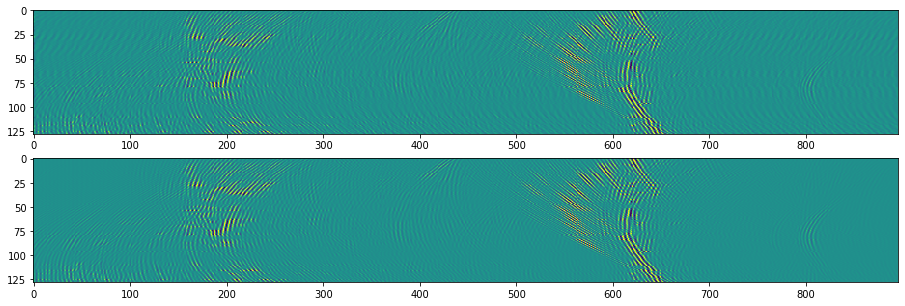

In [ ]:
for img, phantom in full_ds.take(10):
  plt.figure(1,figsize=(20,5))
  plt.subplot(2,1,1)
  plt.imshow(img[:,:,0],vmin=-1,vmax=1)
  plt.subplot(2,1,2)
  plt.imshow(phantom[:,:,0],vmin=-1,vmax=1)
  plt.savefig(os.path.join(working_directory,'sample_data.png'))

In [ ]:
BATCH_SIZE = 10
BUFFER_SIZE = 1000
np.random.seed(42)

def create_dataset(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

def split_data(data, num_samples, split_percentage = [.2, .8]):
  test_size = round(.2 * num_samples)
  train_size = round(.8 * num_samples)
  train_ds = data.take(train_size)
  test_ds = data.skip(train_size)
  test_ds = test_ds.take(test_size)
  train_ds = create_dataset(train_ds)
  test_ds = create_dataset(test_ds) 
  return train_ds, test_ds

In [ ]:
train_data, test_data = split_data(full_ds, num_samples,[.2, .8])
print(test_data)

<PrefetchDataset shapes: ((None, 128, 896, 1), (None, 128, 896, 1)), types: (tf.float32, tf.float32)>


HIFU RF data shape:  (10, 128, 896, 1)
normal RF data shape:  (10, 128, 896, 1)


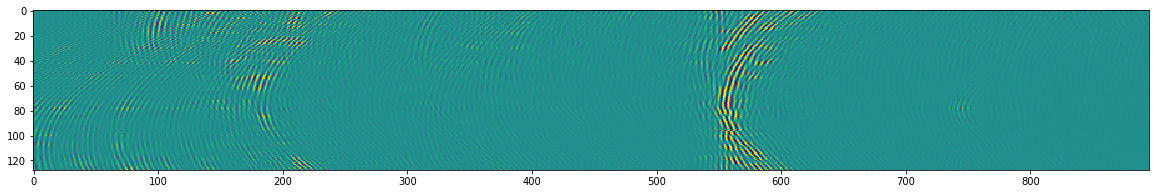

In [ ]:
for ((image),(image2)) in train_data.take(1):
  print("HIFU RF data shape: ", image.numpy().shape)
  print("normal RF data shape: ", image2.numpy().shape)
  plt.figure(1,figsize=(20,10))
  plt.imshow(image[0,:,:,0])

In [ ]:
EPOCHS = 250
log_dir="./logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datenow)

In [ ]:
def generate_images(model, test_input, tar, epoch = 0, checkpoint_dir = '~', savedata = 0):
  prediction = model(test_input, training=True)
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  plt.figure(10,figsize=(25,10))
  for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(np.squeeze(display_list[i]) * 0.5 + 0.5)
    plt.axis('off')
  if (savedata):
    plt.savefig(os.path.join(image_folder,'image_at_epoch_{:04d}.png'.format(epoch)))
    np.save(os.path.join(predictions_folder,'prediction_epoch{:04d}.npy'.format(epoch)),prediction[0])
  plt.show()

In [ ]:
%load_ext tensorboard
#%tensorboard --logdir {log_dir}
%tensorboard --logdir logs/ --host localhost --port 8000

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 16984.

In [ ]:
def Autoencoder():
  input_img = tf.keras.layers.Input(shape=(num_elements, num_samples, 1))  # adapt this if using `channels_first` image data format

  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  #x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  #x = tf.keras.layers.Dropout(0.5)(x)
  #x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  #x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

  encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (7, 7, 32)

  x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  #x = tf.keras.layers.Dropout(0.25)(x)
  #x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
  #x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  #x = tf.keras.layers.Dropout(0.25)(x)

  decoded = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(x)
  
  return tf.keras.Model(inputs = input_img, outputs = decoded)

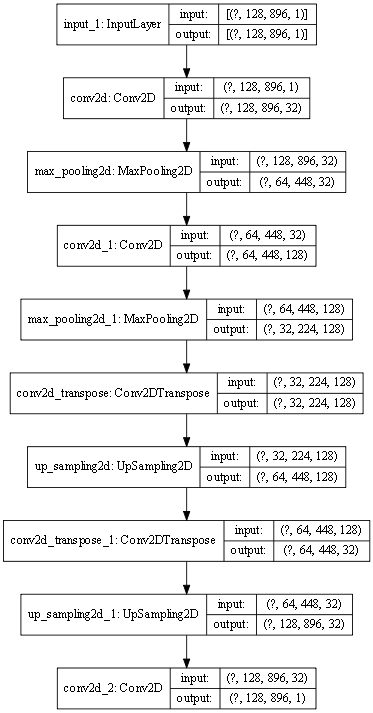

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
autoencoder = Autoencoder()
tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=64)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 896, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 896, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 448, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 448, 128)      36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 224, 128)      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 224, 128)      147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 448, 128)      0     

In [ ]:
def autoencoder_loss(AE_output, target):
  # mean absolute error
  AE_l1_loss = tf.reduce_mean(tf.abs(target - AE_output))
  AE_l2_loss = tf.norm(target - AE_output, ord=2)

  # mean squared error
  AE_MSE = tf.reduce_mean(tf.square(target-AE_output))

  return AE_l1_loss, AE_l2_loss, AE_MSE

In [ ]:
AE_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as AE_tape:
    AE_output = autoencoder(input_image, training=True)

    AE_l1_loss, AE_l2_loss, AE_MSE = autoencoder_loss(AE_output, target)

  AE_gradients = AE_tape.gradient(AE_MSE, autoencoder.trainable_variables)
  
  AE_optimizer.apply_gradients(zip(AE_gradients, autoencoder.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('AE_l1_loss', AE_l1_loss, step = epoch)
    tf.summary.scalar('AE_l2_loss', AE_l2_loss, step = epoch)
    tf.summary.scalar('AE_MSE', AE_MSE, step = epoch)
  
  return AE_l1_loss, AE_l2_loss, AE_MSE

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for (example_input, example_target) in test_ds.take(1):
      generate_images(autoencoder, example_input, example_target, epoch, checkpoint_dir)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      epoch_loss_avg = tf.keras.metrics.Mean()
      epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      AE_l1_loss, AE_l2_loss, AE_MSE = train_step(input_image, target, epoch)
      epoch_loss_avg(AE_l1_loss)
      epoch_accuracy(target,autoencoder(input_image, training = True))
    print()

    # Test
    #test_accuracy = tf.keras.metrics.Accuracy()
    #for n, (input_image, target) in test_ds.enumerate():
    #  test_accuracy(target,autoencoder(input_image, training = False))
    #  with summary_writer.as_default():
    #    tf.summary.scalar('AE_test_accuracy',test_accuracy.result(), step = epoch)

    # saving (checkpoint) the model every 20 epochs
    #if (epoch + 1) % 20 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,epoch_loss_avg.result(),epoch_accuracy.result()))
      #print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
checkpoint_dir = checkpoints_folder
datenow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(checkpoint_dir):
  os.mkdir(os.path.join(checkpoint_dir,datenow))

if not os.path.exists(image_folder):
  os.mkdir(os.path.join(image_folder,datenow))

if not os.path.exists(predictions_folder):
  os.mkdir(os.path.join(predictions_folder,datenow))

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(AE_optimizer=AE_optimizer,
                                 autoencoder=autoencoder)

latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  checkpoint.restore(latest)
else:
  print("Checkpoint not found. Starting from scratch")

NameError: ignored

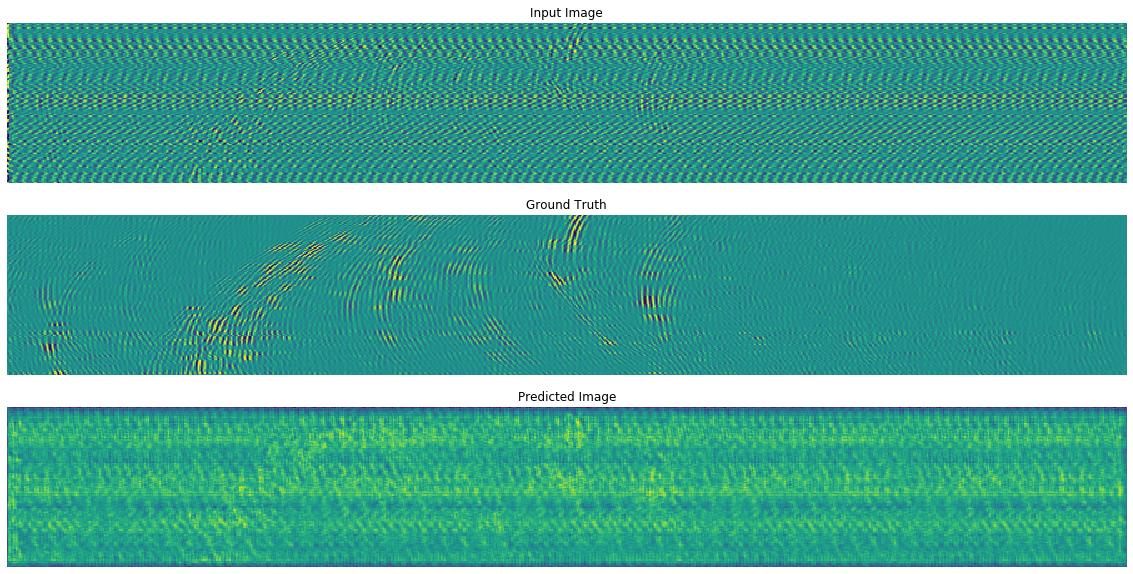

In [ ]:
for (example_input, example_target) in test_data.take(1):
  generate_images(autoencoder, example_input, example_target, 0, checkpoint_dir)

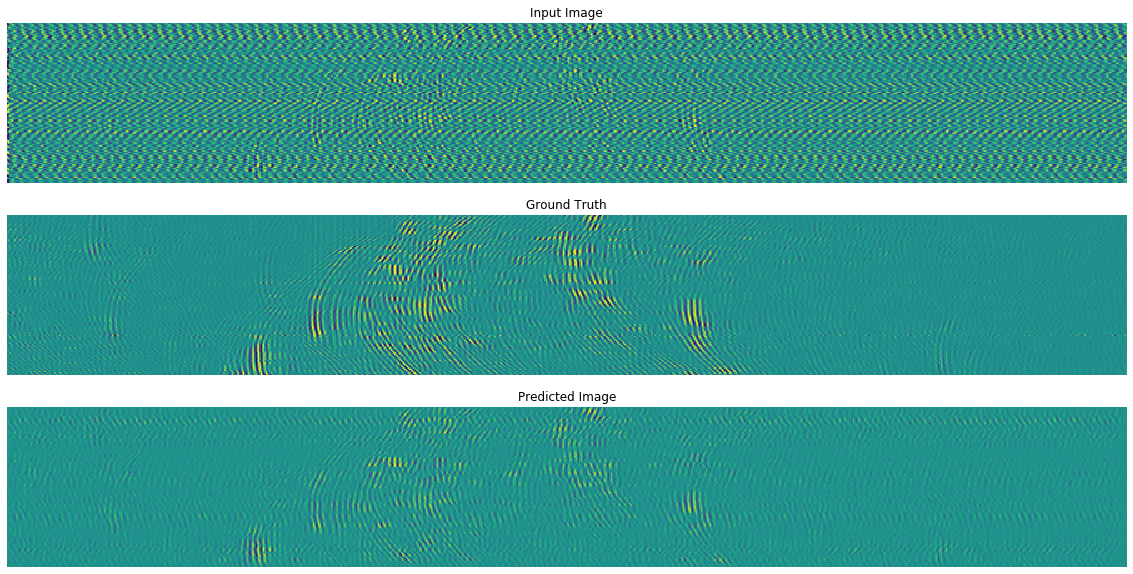

Epoch:  499
........................................................................
Epoch 499: Loss: 0.051, Accuracy: 0.777%
Time taken for epoch 500 is 23.12793755531311 sec



In [ ]:
fit(train_data, EPOCHS, test_data)

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  
  #result.add(tf.keras.layers.Conv2D(filters, size, strides = (1,1), padding='same',kernel_initializer=initializer, use_bias=False))
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=(2,2), padding='same',
                             kernel_initializer=initializer, use_bias=False))
  
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=(2,2),
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  #result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=(1,1),padding='same',kernel_initializer=initializer,use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.3))
  result.add(tf.keras.layers.ReLU())
  return result

In [ ]:
def unet_autoencoder():
  inputs = tf.keras.layers.Input(shape = (num_elements, num_samples, 1))
  initializer = tf.random_normal_initializer(0., 0.02)

  down_filts = [32, 64, 128, 256, 512]
  up_filts = [i for i in reversed(down_filts)]

  down_stack = [
                downsample(down_filts[0], 4, apply_batchnorm=True), # (bs, 48, 726, 64)
                downsample(down_filts[1], 4, apply_batchnorm=True), # (bs, 24, 544, 128)
                downsample(down_filts[2], 4, apply_batchnorm=True), # (bs, 12, 272, 256)
                downsample(down_filts[3], 4, apply_batchnorm=False), # (bs, 6, 136, 512)
                downsample(down_filts[4], 4, apply_batchnorm=False), # (bs, 3, 68, 512)
                #downsample(512, 4), # (bs, 2, 34, 512)
                #downsample(512, 4), # (bs, 1, 17, 512)
                ]
  up_stack = [
              upsample(down_filts[4], 4, apply_dropout=False), # (bs, 2, 34, 1024)
              upsample(down_filts[3], 4, apply_dropout=False), # (bs, 4, 68, 1024)
              upsample(down_filts[2], 4, apply_dropout=False), # (bs, 8, 136, 1024)
              upsample(down_filts[1], 4), # (bs, 16, 272, 1024)
              upsample(down_filts[0], 4), # (bs, 32, 544, 512)
              #upsample(64, 4), # (bs, 64, 1088, 256)
              ]
  last = tf.keras.layers.Conv2DTranspose(1, 4,
                                         strides=(2,2),
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 128, 1664, 3)



  x = inputs
  # Downsampling through the model
  skips = []
  for down, filt in zip(down_stack, down_filts):
    x = tf.keras.layers.Conv2D(filt, 4, strides = (1,1), padding='same',kernel_initializer=initializer, use_bias=False)(x)
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip, filt in zip(up_stack, skips, up_filts):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = tf.keras.layers.Conv2D(filt, 4, strides = (1,1), padding='same',kernel_initializer=initializer, use_bias=False)(x)
  x = tf.keras.layers.Conv2D(32, 4, strides = (1,1), padding='same',kernel_initializer=initializer, use_bias=False)(x)
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)


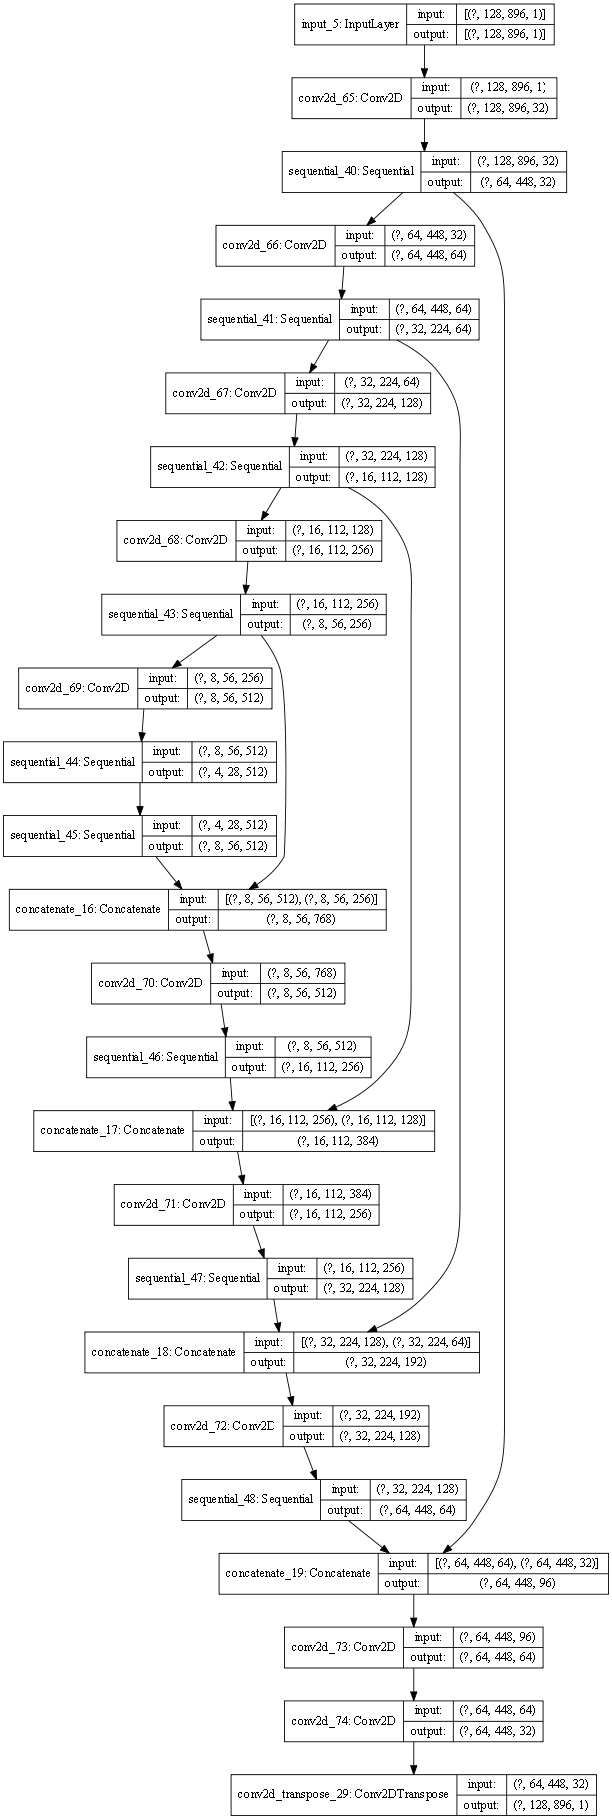

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
unet_AE = unet_autoencoder()
tf.keras.utils.plot_model(unet_AE, show_shapes=True, dpi=64)

In [ ]:
unet_AE.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 896, 1) 0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 128, 896, 32) 512         input_5[0][0]                    
__________________________________________________________________________________________________
sequential_40 (Sequential)      (None, 64, 448, 32)  16512       conv2d_65[0][0]                  
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 64, 448, 64)  32768       sequential_40[0][0]              
____________________________________________________________________________________________

In [ ]:
#unet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
unet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.9)

In [ ]:
checkpoint_dir = checkpoints_folder
datenow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(checkpoint_dir):
  os.mkdir(os.path.join(checkpoint_dir,datenow))

if not os.path.exists(image_folder):
  os.mkdir(os.path.join(image_folder,datenow))

if not os.path.exists(predictions_folder):
  os.mkdir(os.path.join(predictions_folder,datenow))

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(unet_optimizer=unet_optimizer,
                                 unet_AE=unet_AE)

latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  checkpoint.restore(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


In [ ]:
for (example_input, example_target) in train_data.take(1):
  alpha = 0.8
  with tf.GradientTape() as AE_tape:
    AE_output = unet_AE(example_input,training = True)
    MM_SSIM_loss = 1-tf.reduce_mean(tf.image.ssim_multiscale(example_target,AE_output,max_val=2,filter_size=7))
    AE_l1_loss = tf.reduce_mean(tf.abs(example_target-AE_output))
    total_unet_loss = alpha * MM_SSIM_loss + (1-alpha)*AE_l1_loss
    print('alpha*{0} + (1-alpha)*{1} = {2}'.format(MM_SSIM_loss,AE_l1_loss,total_unet_loss))

alpha*0.37364500761032104 + (1-alpha)*0.14770467579364777 = 0.32845693826675415


In [ ]:
def unet_loss(gen_output, target, alpha=0.8):
  #MS_SSIM_loss = tf.reduce_min(-1*tf.reduce_mean(tf.image.ssim(img1=gen_output,img2=target,max_val=2)))
  MS_SSIM_loss = 1-tf.reduce_mean(tf.image.ssim_multiscale(example_target,AE_output,max_val=2,filter_size=3))
  AE_l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_unet_loss = alpha*MS_SSIM_loss + (1-alpha)*AE_l1_loss

  return total_unet_loss, MS_SSIM_loss, AE_l1_loss

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as AE_tape:
    AE_output = unet_AE(input_image, training=True)

    total_unet_loss, MS_SSIM_loss, AE_l1_loss = unet_loss(AE_output, target)

  AE_gradients = AE_tape.gradient(total_unet_loss, unet_AE.trainable_variables)
  
  unet_optimizer.apply_gradients(zip(AE_gradients, unet_AE.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('total_unet_loss', total_unet_loss, step = epoch)
    tf.summary.scalar('MS_SSIM_loss', MS_SSIM_loss, step = epoch)
    tf.summary.scalar('AE_l1_loss', AE_l1_loss, step = epoch)
  
  return total_unet_loss, MS_SSIM_loss, AE_l1_loss

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    # Test
    for (input_image, target) in test_ds:
      test_accuracy = tf.get_static_value(tf.reduce_mean(tf.image.ssim_multiscale(target,unet_AE(input_image, training = False), max_val = 2, filter_size = 7)))
    with summary_writer.as_default():
      tf.summary.scalar('AE_test_accuracy',test_accuracy, step = epoch)

    for (example_input, example_target) in test_ds.take(1):
      generate_images(unet_AE, example_input, example_target, epoch, checkpoint_dir,savedata)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      epoch_loss_avg = tf.keras.metrics.Mean()
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      total_unet_loss, MS_SSIM_loss, l1_loss = train_step(input_image, target, epoch)
      epoch_loss_avg(total_unet_loss)
      epoch_accuracy = tf.get_static_value(tf.reduce_mean(tf.image.ssim_multiscale(target,unet_AE(input_image, training = True), max_val = 2, filter_size = 7)))
    print()



    # saving (checkpoint) the model every 20 epochs
    #if (epoch + 1) % 20 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)
    
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,epoch_loss_avg.result(),epoch_accuracy))
      #print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    if (savedata):
      checkpoint.save(file_prefix = checkpoint_prefix)

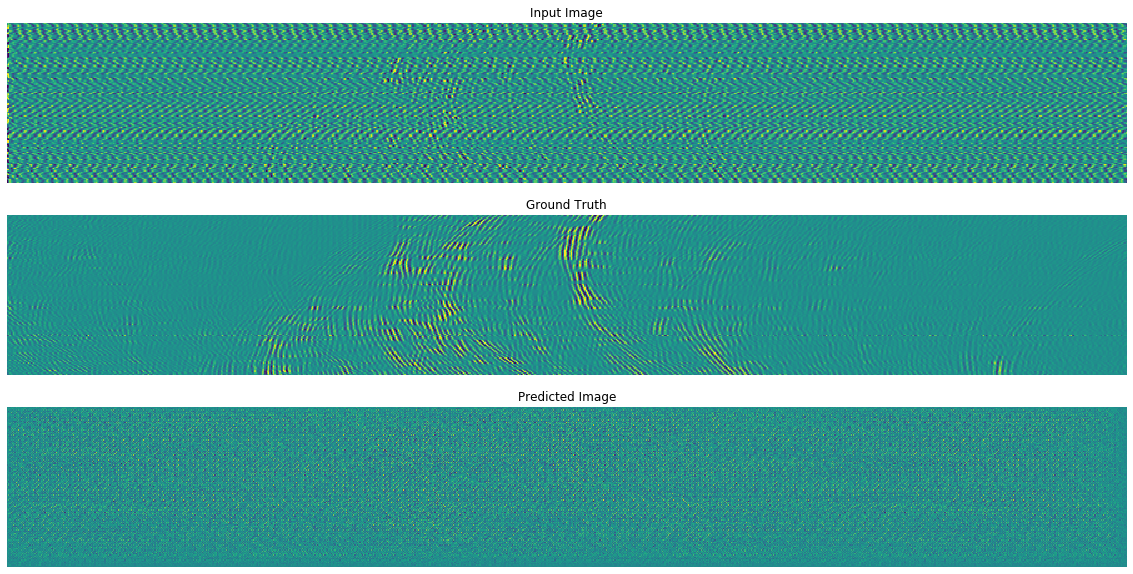

In [ ]:
for (example_input, example_target) in test_data.take(1):
  generate_images(unet_AE, example_input, example_target, 0, checkpoint_dir)

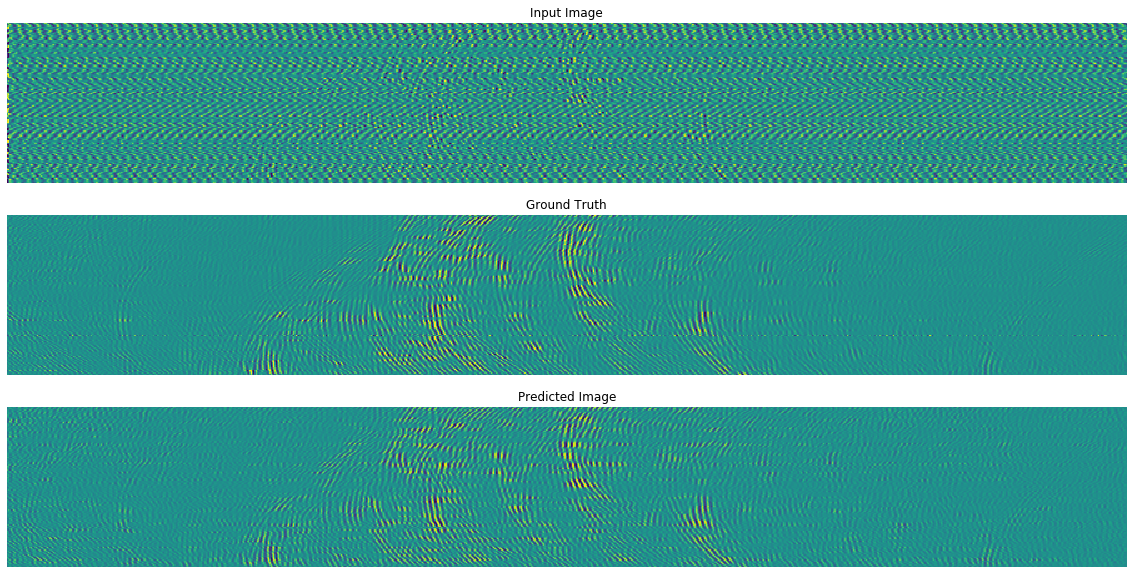

Epoch:  217
..................................

In [ ]:
fit(train_data, EPOCHS, test_data)